In [1]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from skimage import io, filters, morphology, segmentation, measure, exposure
from skimage.restoration import denoise_wavelet

### Functions

In [3]:
# Adaptive sigmoid to pull out signal
def sigmoid_adjustment(image, std_dev_mult=1.5, alpha=.5):

    # Get mean and standard deviation of image
    mean_val = np.mean(image)
    std_dev = np.std(image)

    # Set the midpoint for the sigmoid function to 1 standard deviation above the mean * arbitrary multiplier
    midpoint = mean_val + std_dev * std_dev_mult

    # Apply the sigmoid function to adjust image contrast
    # 'alpha' controls the steepness of the sigmoid curve
    adjusted_image = 1 / (1 + np.exp(-alpha * (image - midpoint)))

    # Scale back to 0-255 and convert to uint8
    adjusted_image = np.uint8(255 * (adjusted_image - adjusted_image.min()) / (adjusted_image.max() - adjusted_image.min()))

    return adjusted_image

# Helper functions
def add_padding(img, pad_width):
    return np.pad(img, pad_width, mode='constant', constant_values=0)

def remove_padding(img, pad_width):
    return img[pad_width:-pad_width, pad_width:-pad_width] if pad_width > 0 else img

def scale_to_uint8(img):
    return ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)

def log_scale(img):
    img = np.clip(img, a_min=1, a_max=None)  # Avoid log(0)
    return (np.log(img) / np.log(img.max()) * 255).astype(np.uint8)

# Normalize between 0 and 1, then multiply by 255
def normalize_img(image):
    image = image.astype(float)
    image -= np.amin(image.astype(float))
    image /= np.amax(image)
    return image * 255


In [4]:
def resize_stack(input_stack, new_size=(512, 512)):

    assert len(input_stack.shape) == 3, "Please select a single timepoint. Array should be z*x*y"
    assert input_stack.shape[1] > input_stack.shape[0] < input_stack.shape[2], "Please make sure dim 0 is thin (z) dimension"
    assert len(new_size) == 2, "new_size must be a len=2 tuple or list."

    # Pre-allocate the resized array with the new dimensions
    resized_stack = np.zeros((input_stack.shape[0], new_size[0], new_size[1]), dtype=input_stack.dtype)

    for z in range(input_stack.shape[0]):  # Loop over slices
        # Convert to np.uint8, then resize slice and add it to new array
        slice = input_stack[z,:,:].astype(np.uint8)
        slice = cv2.resize(slice, new_size, interpolation=cv2.INTER_LINEAR)
        resized_stack[z,:,:] = slice

    return resized_stack

In [5]:
def binarize_stack(input_stack, new_size=(512, 512)):
    assert len(new_size) == 2, "new_size must be a len=2 tuple or list."

    # Pre-allocate the resized array with the new dimensions
    resized_stack = np.zeros((input_stack.shape[0], new_size[0], new_size[1]), dtype=input_stack.dtype)

    for z in range(input_stack.shape[0]):  # Loop over slices

        image = input_stack[z, :, :]

        denoised_image = denoise_wavelet(image, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma=True)

        thresh_img = sigmoid_adjustment(denoised_image, 3)

        blank = np.ones_like(image)
        thresh_img = np.where(thresh_img > 12, blank, 0)

        slice = cv2.resize(thresh_img, new_size, interpolation=cv2.INTER_LINEAR)
        resized_stack[z,:,:] = slice
        
        #print(f"slice {z}")

    return resized_stack

In [6]:
def mask_stack(input_stack, new_size=(512, 512), sigmoid=True, threshold=3):

    assert len(input_stack.shape) == 3, "Please select a single timepoint. Array should be z*x*y"
    assert input_stack.shape[1] > input_stack.shape[0] < input_stack.shape[2], "Please make sure dim 0 is thin (z) dimension"
    assert len(new_size) == 2, "new_size must be a len=2 tuple or list."

    # Pre-allocate the resized array with the new dimensions
    masked_stack = np.zeros((input_stack.shape[0], new_size[0], new_size[1]), dtype=input_stack.dtype)

    # Compute Maximum Intensity Projection
    mip = np.max(input_stack, axis=0)
    mip = normalize_img(mip)
    
    # Create mask
    blank = np.zeros_like(mip)
    mip_mask = np.where(mip < threshold, blank, 1) 

    # Loop over slices
    for z in range(input_stack.shape[0]):  

        slice = normalize_img(input_stack[z,:,:])

        if sigmoid:
            slice = sigmoid_adjustment(slice, 3)

        masked_image = slice * mip_mask

        slice = cv2.resize(masked_image, new_size, interpolation=cv2.INTER_LINEAR)

        masked_stack[z,:,:] = slice

    return masked_stack, mip_mask

In [7]:
def sliding_window_mip(image_stack, window_thickness):

    assert len(image_stack.shape) == 3, "Please select a single timepoint. Array should be z*x*y"
    assert image_stack.shape[1] > image_stack.shape[0] < image_stack.shape[2], "Please make sure dim 0 is thin (z) dimension"

    depth = image_stack.shape[0]
    mip_output = np.zeros_like(image_stack)
    
    for z in range(depth):
        # Define the window range
        start_slice = max(0, z - window_thickness // 2)
        end_slice = min(depth, z + window_thickness // 2 + 1)
        
        # Apply MIP within the window
        mip_output[z, :, :] = np.max(image_stack[start_slice:end_slice], axis=0)
    
    return mip_output

## Load Raw Stack

In [8]:
# Load image stack
stack = io.imread('stacks/exp240202_01_E.tif')

### Sliding Window MIP

In [17]:
mip_win_stack = sliding_window_mip(stack[0,:,:,:], window_thickness=3)
print(f"{np.amax(mip_win_stack)}")
print(f"{np.amin(mip_win_stack)}")
print(f"{mip_win_stack.shape}")

1741
86
(188, 2044, 2042)


### Mask Stack To Remove Background

In [18]:
# Clean up the image, remove small objects, optional close operation
#cleaned_stack = morphology.remove_small_objects(mip_win_stack, min_size=16)
#cleaned_stack = morphology.binary_closing(cleaned_stack, footprint=morphology.ball(1))

In [19]:
# Mask stack using MIP binary mask
masked_stack, mip_mask = mask_stack(cleaned_stack, new_size=(512,512), sigmoid=False)

In [24]:
# Delete original stack to save memory
del stack

In [25]:
#size = 1024

# Make resized stack
#processed_stack = resize_stack(mip_win_stack, (size, size))

### Preview Slices

Text(0.5, 1.0, 'Sliding Window MIP Slice 32')

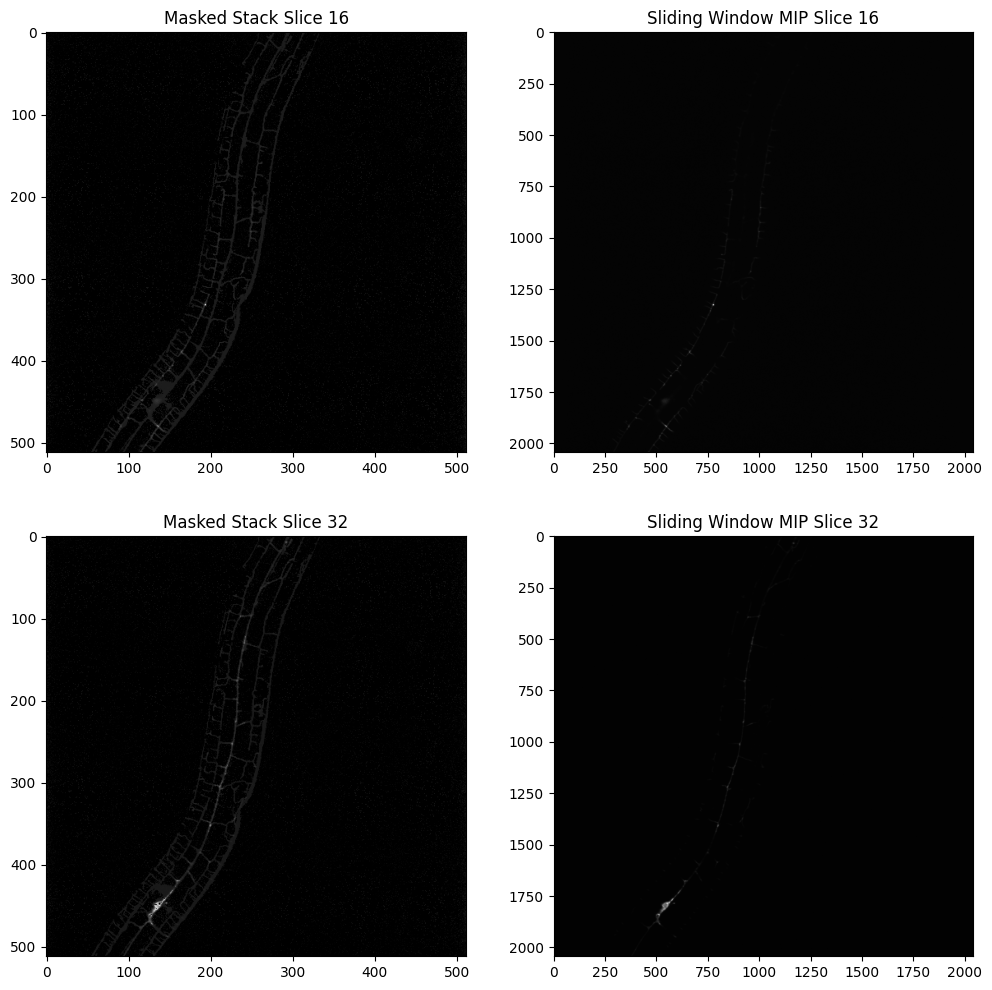

In [21]:
# Visualize some MIP outputs
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

preview_slices = [16,32]

# Full stack MIP
mip_image = masked_stack[preview_slices[0],:,:]
# Sliding window MIP slice 1
mip_slice_1 = mip_win_stack[preview_slices[0],:,:]
# Sliding window MIP slice 1
mip_slice_2 = masked_stack[preview_slices[1],:,:]
# Sliding window MIP slice 1
mip_slice_3 = mip_win_stack[preview_slices[1],:,:]

axs[0, 0].imshow(mip_image, cmap='gray')
axs[0, 0].set_title(f'Masked Stack Slice {preview_slices[0]}')

axs[0, 1].imshow(mip_slice_1, cmap='gray')
axs[0, 1].set_title(f'Sliding Window MIP Slice {preview_slices[0]}')

axs[1, 0].imshow(mip_slice_2, cmap='gray')
axs[1, 0].set_title(f'Masked Stack Slice {preview_slices[1]}')

axs[1, 1].imshow(mip_slice_3, cmap='gray')
axs[1, 1].set_title(f'Sliding Window MIP Slice {preview_slices[1]}')


### Plot

In [27]:
plot_stack = masked_stack[16:100, :, :]

# Plot Data Info
print(plot_stack.shape)
print(np.amax(plot_stack))
print(np.amin(plot_stack))

(84, 512, 512)
249
0


In [29]:
# Prepare data for plotting
image_stack = np.transpose(plot_stack, (1, 2, 0))
x, y, z = image_stack.shape

Y, X, Z = np.meshgrid(np.arange(y), np.arange(x), np.arange(z))

colors = image_stack.ravel()  # Flatten the color intensity values

# Separate visible and invisible points
visible_mask = colors > 4

# Coordinates of points
x_coords = X.ravel()[visible_mask]
y_coords = Y.ravel()[visible_mask]
z_coords = Z.ravel()[visible_mask]
colors = colors[visible_mask]

# Define cube size
cube_size = 1

# Define vertices of a unit cube centered at (0,0,0)
vertices_base = np.array([
    [-0.5, -0.5, -0.5],
    [0.5, -0.5, -0.5],
    [0.5, 0.5, -0.5],
    [-0.5, 0.5, -0.5],
    [-0.5, -0.5, 0.5],
    [0.5, -0.5, 0.5],
    [0.5, 0.5, 0.5],
    [-0.5, 0.5, 0.5]
]) * cube_size

# Triangular faces of the cube
faces = [
    [0, 1, 2], [0, 2, 3],
    [4, 5, 6], [4, 6, 7],
    [0, 1, 5], [0, 5, 4],
    [2, 3, 7], [2, 7, 6],
    [0, 4, 7], [0, 7, 3],
    [1, 5, 6], [1, 6, 2]
]

# Create vertices and i, j, k lists for Mesh3d
vertices = []
i, j, k = [], [], []
for idx in range(len(x_coords)):
    # Shift vertices to the correct position
    new_vertices = vertices_base + [x_coords[idx], y_coords[idx], z_coords[idx]]
    vertices.append(new_vertices)
    base_index = 8 * idx
    for face in faces:
        i.append(base_index + face[0])
        j.append(base_index + face[1])
        k.append(base_index + face[2])

# Flatten the vertices array for use in Mesh3d
vertices = np.array(vertices).reshape(-1, 3)

# Create a 3D mesh plot
fig = go.Figure(data=[
    go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=i,
        j=j,
        k=k,
        facecolor=[f'rgb({c},{c},{c})' for c in colors],  # Color based on intensity
        opacity=0.5
    )
])

# Update layout for better viewing
fig.update_layout(
    title='3D Mesh Plot of Image Stack with Cubes',
    scene=dict(
        xaxis_title='X (pixels)',
        yaxis_title='Y (pixels)',
        zaxis_title='Z (image index)',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.05)  # Adjust z-axis scale; modify as needed
    ),
    autosize=False,
    width=800,
    height=600
)

# Show the figure
fig.show()
